# Flight Price Prediction Notebook

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Datasets

In [6]:
train_df = pd.read_excel('Data_Train.xlsx')

## Display Basic Info

In [7]:
print("Train Data Shape:", train_df.shape)

Train Data Shape: (10683, 11)


In [8]:
print("\nTrain Data Columns:", train_df.columns.tolist())


Train Data Columns: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']


In [9]:
display(train_df.head())

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Exploratory Data Analysis (EDA)

In [10]:
# Check for missing values
print("\nMissing Values in Train Data:")
print(train_df.isnull().sum())


Missing Values in Train Data:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


## Data Preprocessing

In [11]:
# Fill missing values
most_frequent_route = train_df['Route'].mode()[0]
train_df['Route'].fillna(most_frequent_route, inplace=True)
most_common_stops = train_df['Total_Stops'].mode()[0]
train_df['Total_Stops'].fillna(most_common_stops, inplace=True)

# Check if missing values are gone
print("\nMissing Values After Imputation:")
print(train_df.isnull().sum())


Missing Values After Imputation:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64


In [12]:
# Convert Date_of_Journey to datetime and extract features
train_df['Date_of_Journey'] = pd.to_datetime(train_df['Date_of_Journey'], format='%d/%m/%Y')
train_df['Journey_Day'] = train_df['Date_of_Journey'].dt.day
train_df['Journey_Month'] = train_df['Date_of_Journey'].dt.month
train_df['Journey_Year'] = train_df['Date_of_Journey'].dt.year

# Convert Dep_Time and Arrival_Time
train_df['Dep_Hour'] = pd.to_datetime(train_df['Dep_Time'], format='%H:%M').dt.hour
train_df['Dep_Min'] = pd.to_datetime(train_df['Dep_Time'], format='%H:%M').dt.minute
train_df['Arrival_Hour'] = pd.to_datetime(train_df['Arrival_Time'].str.split(' ').str[0], format='%H:%M', errors='coerce').dt.hour
train_df['Arrival_Min'] = pd.to_datetime(train_df['Arrival_Time'].str.split(' ').str[0], format='%H:%M', errors='coerce').dt.minute

# Handle potential NaT in Arrival_Hour and Arrival_Min
train_df['Arrival_Hour'].fillna(train_df['Arrival_Hour'].mode()[0], inplace=True)
train_df['Arrival_Min'].fillna(train_df['Arrival_Min'].mode()[0], inplace=True)

# Convert Duration to minutes
def duration_to_minutes(duration):
    try:
        hours = 0
        minutes = 0
        if 'h' in duration:
            hours = int(duration.split('h')[0])
            if 'm' in duration:
                minutes = int(duration.split('h')[1].split('m')[0])
        elif 'm' in duration:
            minutes = int(duration.split('m')[0])
        return hours * 60 + minutes
    except:
        return 0  # Handle malformed duration strings

train_df['Duration_Mins'] = train_df['Duration'].apply(duration_to_minutes)

# Encode Additional_Info
train_df['Meal_Included'] = train_df['Additional_Info'].apply(lambda x: 0 if x == 'No info' else 1)

## Outlier Detection and Handling

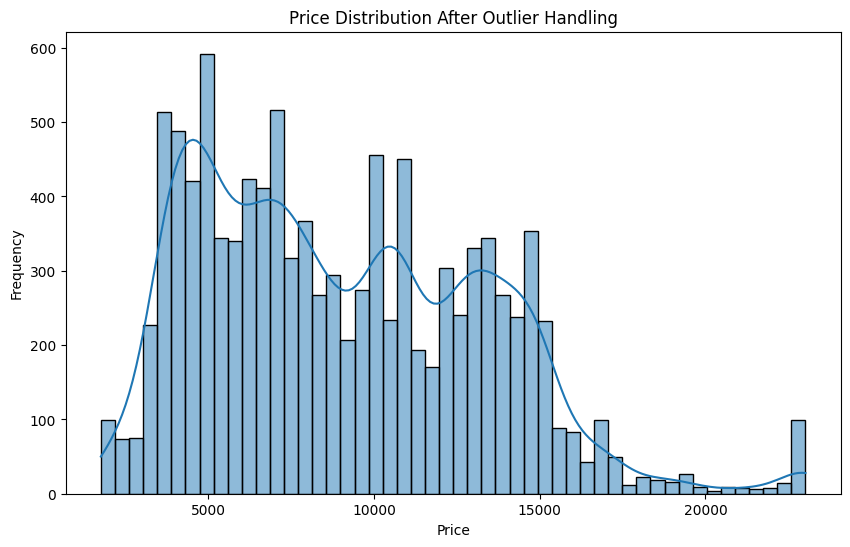

In [13]:
# Detect outliers in Price using IQR method
Q1 = train_df['Price'].quantile(0.25)
Q3 = train_df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers
train_df['Price'] = train_df['Price'].clip(lower=lower_bound, upper=upper_bound)

# Visualize Price distribution after outlier handling
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Price'], bins=50, kde=True)
plt.title('Price Distribution After Outlier Handling')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

## Feature Correlation Analysis

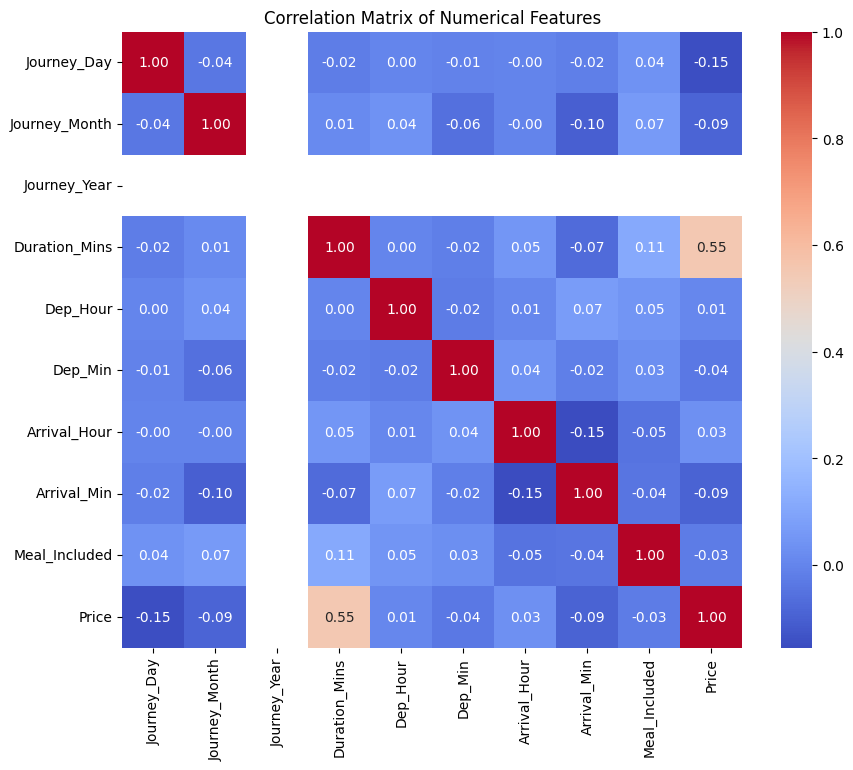

In [14]:
# Select numerical features for correlation analysis
numerical_cols = ['Journey_Day', 'Journey_Month', 'Journey_Year', 'Duration_Mins', 'Dep_Hour', 'Dep_Min', 'Arrival_Hour', 'Arrival_Min', 'Meal_Included', 'Price']

# Compute correlation matrix
corr_matrix = train_df[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Data Preparation for Modeling

In [15]:
display(train_df.head())

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,Duration_Mins,Meal_Included
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,170,0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2019,5,50,13,15,445,0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,2019,9,25,4,25,1140,0
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,2019,18,5,23,30,325,0
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,2019,16,50,21,35,285,0


In [16]:
# Define features and target
X = train_df.drop(['Price', 'Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration', 'Additional_Info'], axis=1)
y = train_df['Price']

# Define categorical and numerical columns
cat_cols = ['Airline', 'Source', 'Destination', 'Route', 'Total_Stops']
num_cols = ['Journey_Day', 'Journey_Month', 'Journey_Year', 'Duration_Mins', 'Dep_Hour', 'Dep_Min', 'Arrival_Hour', 'Arrival_Min', 'Meal_Included']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

In [17]:
# Create a temporary pipeline for feature selection
temp_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ]), cat_cols)
    ])

# Fit the preprocessor
X_train_transformed = temp_preprocessor.fit_transform(X_train)

# Get feature names after transformation
cat_feature_names = temp_preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
feature_names = num_cols + cat_feature_names.tolist()

# Perform feature selection using RandomForest
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
selector.fit(X_train_transformed, y_train)

# Get selected features
selected_features = [feature_names[i] for i in range(len(feature_names)) if selector.get_support()[i]]
print("Selected Features:", selected_features)

Selected Features: ['Journey_Day', 'Journey_Month', 'Duration_Mins', 'Dep_Hour', 'Dep_Min', 'Arrival_Hour', 'Arrival_Min', 'Meal_Included', 'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Vistara', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi', 'Route_BLR → BOM → BHO → DEL', 'Route_BLR → BOM → DEL', 'Route_BLR → BOM → IDR → DEL', 'Route_BLR → BOM → NAG → DEL', 'Route_BLR → CCU → BBI → DEL', 'Route_BLR → DEL', 'Route_BLR → HYD → DEL', 'Route_BLR → HYD → VGA → DEL', 'Route_BLR → MAA → DEL', 'Route_BLR → PNQ → DEL', 'Route_BOM → GOI → PNQ → HYD', 'Route_BOM → HYD', 'Route_BOM → JDH → DEL → HYD', 'Route_BOM → JDH → JAI → DEL → HY

## Model Pipeline

In [20]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ]), cat_cols)
    ])

# Random Forest model with tuned hyperparameters
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42))
])

# Train and evaluate Random Forest
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

print("\nRandom Forest Performance:")
print(f"MAE: {mean_absolute_error(y_val, rf_pred)}")
print(f"R2 Score: {r2_score(y_val, rf_pred)}")

# Cross-validation score
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Random Forest CV R2 Scores: {rf_cv_scores}")
print(f"Average CV R2 Score: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")


Random Forest Performance:
MAE: 587.8571927524752
R2 Score: 0.9293579545896131
Random Forest CV R2 Scores: [0.92839472 0.93459769 0.93066815 0.91715094 0.92044   ]
Average CV R2 Score: 0.9263 (+/- 0.0130)


In [21]:
# XGBoost model with tuned hyperparameters
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42))
])

# Train and evaluate XGBoost
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

print("\nXGBoost Performance:")
print(f"MAE: {mean_absolute_error(y_val, xgb_pred)}")
print(f"R2 Score: {r2_score(y_val, xgb_pred)}")

# Cross-validation score
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print(f"XGBoost CV R2 Scores: {xgb_cv_scores}")
print(f"Average CV R2 Score: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")


XGBoost Performance:
MAE: 889.6056200669199
R2 Score: 0.8984797990507266
XGBoost CV R2 Scores: [0.91221496 0.90505718 0.91466752 0.90948071 0.89855235]
Average CV R2 Score: 0.9080 (+/- 0.0114)


In [22]:
# Select the best model based on validation R2 score
final_model = rf_model if r2_score(y_val, rf_pred) > r2_score(y_val, xgb_pred) else xgb_model
print(f"\nSelected Model: {'Random Forest' if final_model == rf_model else 'XGBoost'}")


Selected Model: Random Forest


In [23]:
# Retrain on full data
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Journey_Day',
                                                   'Journey_Month',
                                                   'Journey_Year',
                                                   'Duration_Mins', 'Dep_Hour',
                                                   'Dep_Min', 'Arrival_Hour',
                                                   'Arrival_Min',
                                                   'Meal_Included']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Airline', 'Source',
                                                   'Destination', 'Route',
                                                   'Total_Stops'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=200,
                                       random_state=42))])

In [24]:
# Save the model pipeline
joblib.dump(final_model, 'flight_price_model.joblib')

['flight_price_model.joblib']

In [25]:
# Save the column names for later use
model_metadata = {
    'features': X.columns.tolist(),
    'categorical_cols': cat_cols,
    'numerical_cols': num_cols
}
joblib.dump(model_metadata, 'model_metadata.joblib')

['model_metadata.joblib']

In [26]:
print("\nModel saved successfully!")


Model saved successfully!


In [27]:
def predict_flight_price(input_features):
    """
    Predict flight price given input features
    Expected input format: Dictionary with keys matching training columns
    """
    # Load model and metadata
    model = joblib.load('flight_price_model.joblib')
    metadata = joblib.load('model_metadata.joblib')
    
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_features])
    
    # Ensure all columns are present
    for col in metadata['features']:
        if col not in input_df.columns:
            input_df[col] = np.nan
    
    # Reorder columns
    input_df = input_df[metadata['features']]
    
    # Predict
    prediction = model.predict(input_df)
    return prediction[0]

In [28]:
# Example usage
sample_input = {
    'Airline': 'Indigo',
    'Source': 'Banglore',
    'Destination': 'New Delhi',
    'Route': 'BLR → DEL',
    'Total_Stops': 'non-stop',
    'Journey_Day': 15,
    'Journey_Month': 7,
    'Journey_Year': 2023,
    'Duration_Mins': 170,
    'Dep_Hour': 10,
    'Dep_Min': 30,
    'Arrival_Hour': 13,
    'Arrival_Min': 20,
    'Meal_Included': 0
}

print("\nSample Prediction:")
print(f"Predicted Price: ₹{predict_flight_price(sample_input):.2f}")


Sample Prediction:
Predicted Price: ₹6531.13
